<a href="https://colab.research.google.com/github/AmlKamal/palmyra/blob/master/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Check OS**

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic


In [ ]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (40.5 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure:

### Importing the dataset

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **View Dataset Details**

In [ ]:
ls "/content/drive/My Drive/Malaria Detection /CNN/"

Parasitized/  Uninfected/


In [ ]:
!tree --dirsfirst --filelimit 5 "/content/drive/My Drive/Malaria Detection /CNN/"

/content/drive/My Drive/Malaria Detection /CNN/
├── Parasitized [error opening dir]
└── Uninfected [13905 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
import os
import glob

base_dir = os.path.join('/content/drive/My Drive/Malaria Detection /CNN/')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13864, 13904)

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/drive/My Drive/Malaria Detection /CNN...,malaria
1,/content/drive/My Drive/Malaria Detection /CNN...,malaria
2,/content/drive/My Drive/Malaria Detection /CNN...,healthy
3,/content/drive/My Drive/Malaria Detection /CNN...,malaria
4,/content/drive/My Drive/Malaria Detection /CNN...,healthy


## **Create Train, Validation and Test Datasets**

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17493,) (1944,) (8331,)
Train: Counter({'healthy': 8789, 'malaria': 8704}) 
Val: Counter({'healthy': 974, 'malaria': 970}) 
Test: Counter({'malaria': 4190, 'healthy': 4141})


## **Get Image Dimension Summary Stats**

In [ ]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_2: working on img num: 5000
ThreadPoolExecutor-0_3: working on img num: 10000
ThreadPoolExecutor-0_14: working on img num: 15000
ThreadPoolExecutor-0_10: working on img num: 17492
Min Dimensions: [40 46  3]
Avg Dimensions: [133.07442977 132.44126222   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 394   3]


### **Load and Resize Images**

In [ ]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_12: working on img num: 5000
ThreadPoolExecutor-1_5: working on img num: 10000
ThreadPoolExecutor-1_13: working on img num: 15000
ThreadPoolExecutor-1_7: working on img num: 17492

Loading Validation Images:
ThreadPoolExecutor-1_1: working on img num: 0
ThreadPoolExecutor-1_0: working on img num: 1943

Loading Test Images:
ThreadPoolExecutor-1_18: working on img num: 0
ThreadPoolExecutor-1_17: working on img num: 5000
ThreadPoolExecutor-1_18: working on img num: 8330


((17493, 125, 125, 3), (1944, 125, 125, 3), (8331, 125, 125, 3))

### **View Sample Cell Images**

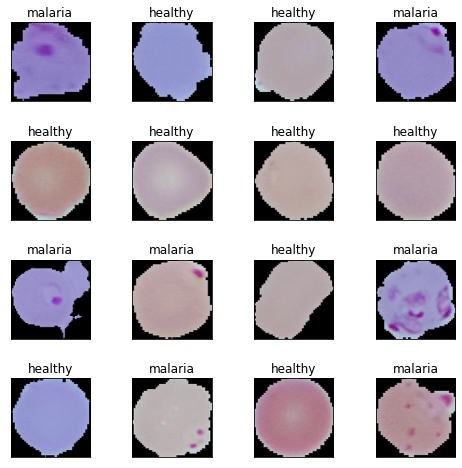

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

### **Setup config settings, Scale Images & Label encode classes**

In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 6
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['healthy' 'healthy' 'malaria' 'healthy' 'healthy' 'healthy'] [0 0 1 0 0 0]


In [ ]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 34kB/s 
     |████████████████████████████████| 3.8MB 66.7MB/s 
     |████████████████████████████████| 450kB 64.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a353e76a76a41d6630a68a720eba6f6e1dc2c7bf106e992b0b93f1a3693c5066
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: t

In [ ]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

tf.random.set_seed(42)
tf.__version__

'2.0.0'

### **Model 1: CNN from Scratch**

### **Build Model Architecture**

In [ ]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)

hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

**Image Augmentaion**


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['healthy', 'healthy', 'healthy', 'healthy', 'healthy']


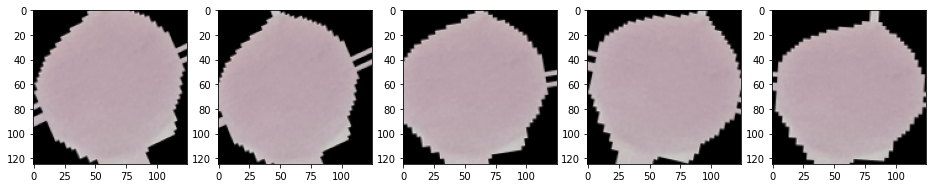

In [ ]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [ ]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

### **Train Model**

In [ ]:
import datetime

logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=6, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Train on 17493 samples, validate on 1944 samples
Epoch 1/10
17493/17493 [==============================] - 273s 16ms/sample - loss: 0.3939 - accuracy: 0.8197 - val_loss: 0.1822 - val_accuracy: 0.9434
Epoch 2/10
17493/17493 [==============================] - 270s 15ms/sample - loss: 0.1676 - accuracy: 0.9478 - val_loss: 0.1578 - val_accuracy: 0.9522
Epoch 3/10
17493/17493 [==============================] - 271s 15ms/sample - loss: 0.1366 - accuracy: 0.9567 - val_loss: 0.1380 - val_accuracy: 0.9532
Epoch 4/10
17493/17493 [==============================] - 266s 15ms/sample - loss: 0.1201 - accuracy: 0.9596 - val_loss: 0.1402 - val_accuracy: 0.9527
Epoch 5/10
17493/17493 [==============================] - 266s 15ms/sample - loss: 0.1071 - accuracy: 0.9640 - val_loss: 0.1320 - val_accuracy: 0.9583
Epoch 6/10
17493/17493 [==============================] - 266s 15ms/sample - loss: 0.0892 - accuracy: 0.9695 - val_loss: 0.1606 - val_accuracy: 0.9527
Epoch 7/10
17493/17493 [=====================

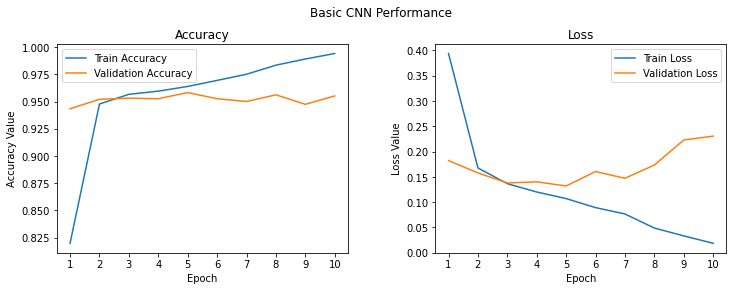

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### **Save Model**

In [ ]:
model.save('basic_aug_cnn2_10.h5')

### **Transfar learning**

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential 

In [ ]:
weights_path = './basic_aug_cnn2_10.h5'
num_classes = 2
testing_model = Sequential()
testing_model.add(basic_aug_cnn2_10(include_top=False,weights=weights_path,pooling='avg'))
testing_model.add(Dense(num_classes,activation='softmax'))
testing_model.layers[0].trainable = False

In [ ]:
testing_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tenserflow.python.keras.preprocessing.image import ImageDataGenrator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = data_generator.flow_from_directory(
                                'google drive path for traning file',
                                target_size=(image_size,image_size),
                                batch_size=12,
                                class_mode='categorical')

In [ ]:
validation_generator = data_generator.flow_from_directory(
                                'google drive path for validation file',
                                target_size=(image_size,image_size),
                                batch_size=20,
                                class_mode='categorical')

In [ ]:
testing_model.fit_generator(train_generator,
                            steps_per_epoch=6,
                            validation_date=validation_generator,
                            validation_steps=1)

In [ ]:
model.save('transfer_learning.h5')

### preparing for the evaluation 

In [ ]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape


NameError: ignored

In [ ]:
len(test_data)

8331

In [ ]:
! ls -l --block-size=MB | grep .h5

-rw-r--r-- 1 root root 182MB Jul  3 17:12 basic_aug_cnn2.h5


In [ ]:
basic_cnn = tf.keras.models.load_model('./basic_aug_cnn2.h5')

In [ ]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])

### **Parasitima level**

In [ ]:
cnn_preds_parasitimia = basic_cnn.predict(test_imgs_scaled, batch_size=512)
para_counter=0
sum = 0 
for i in  cnn_preds_parasitimia.ravel():
  if i > 0.5:
    para_counter=para_counter+1
  sum = sum+1
  if sum == 500:
    break
precentage = (para_counter/sum)*100
print ('number of infected cells ', para_counter)
print ('number of infected cells ',sum)
print ('Parasitimia' , precentage)


number of infected cells  245
number of infected cells  500
Parasitimia 49.0


### Confusion matrix 

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 



In [ ]:
cf_matrix = confusion_matrix(test_labels,basic_cnn_pred_labels)
print(cf_matrix)

specificity = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
print (specificity)

[[3957  184]
 [ 214 3976]]
0.948926014319809


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


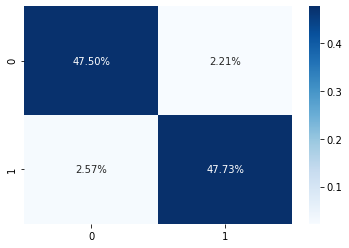

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

### Accuracy 

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(test_labels,basic_cnn_pred_labels)

In [ ]:
Error_rate=1-(accuracy)

print(Error_rate)

#print(Error_rate*100)


0.04777337654543268


### precision

In [ ]:
from sklearn.metrics import precision_score
positive = precision_score(test_labels,basic_cnn_pred_labels,pos_label='healthy')
print(positive)

0.948693358906737


In [ ]:
negative = precision_score(test_labels,basic_cnn_pred_labels,pos_label='malaria')
print(negative)

0.9557692307692308


### recall

In [ ]:
from sklearn.metrics import recall_score
positive = recall_score(test_labels,basic_cnn_pred_labels,pos_label='healthy')
print(positive)

0.9555662883361506


In [ ]:
negative = recall_score(test_labels,basic_cnn_pred_labels,pos_label='malaria')
print(negative)

0.948926014319809


### f1_score

In [ ]:
from sklearn.metrics import f1_score
postive = f1_score(test_labels,basic_cnn_pred_labels,pos_label='healthy')
print(postive)

0.9521174205967277


In [ ]:
negative = f1_score(test_labels,basic_cnn_pred_labels,pos_label='malaria')
print(negative)

0.9523353293413173


### **specificity**

In [ ]:
specificity = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
print (specificity)

0.948926014319809


### **ROC**

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import sklearn.metrics as metrics
#probs = model.predict_proba(X_test)
#preds = basic_cnn_pred_labels[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels[:,1],basic_cnn_pred_labels[:,1])
roc_auc = metrics.auc(fpr, tpr)

#TPR = TP/(TP+FN) recall 
#from sklearn.metrics import recall_score
#tpr = recall_score(test_labels,basic_cnn_pred_labels,pos_label='healthy')
#print('tpr',tpr)
#FPR = FP/(FP+TN) False negative rate [fix]
#fpr = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
#print (fpr)


fpr, tpr, _ = roc_curve(test_labels,basic_cnn_pred_labels,pos_label='healthy')
#skplt.metrics.plot_roc_curve(fpr, tpr)
#plt.plot(fpr, tpr)
#plt.show()

#x = # false_positive_rate
#y = # true_positive_rate 

In [ ]:
!pip install scikit-plot

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_labels,basic_cnn_pred_labels)


### **classification report**

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(test_labels,basic_cnn_pred_labels)
print(report)

**وااااااااااااااااااااااااااااااااااااااااااااااااااااي**

### **Testing the model on actual data**

In [ ]:
#import os
#import glob
#import cv2
#img_dir = os.path.join('/content/drive/My Drive/Malaria Detection /test/')
#data_path = os.path.join(img_dir,'*g')
#files = glob.glob(data_path)
#images = []
#for f1 in files:
#  img = cv2.imread(f1)
#  images.append(img)

In [ ]:
#from google.colab import files
#uploaded = files.upload()
#import cv2 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
ls "/content/drive/My Drive/Malaria Detection /test/"

In [ ]:
from keras.models import load_model
classifier = tf.keras.models.load_model('./basic_aug_cnn.h5')

In [ ]:
classifier.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])


In [ ]:
import numpy as np
from keras.preprocessing import image
import numpy as np
import cv2
from google.colab import files
from matplotlib import pyplot as plt
from IPython.display import Image

import os
import glob
import cv2

img_dir = os.path.join('/content/drive/My Drive/Malaria Detection /test/')
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
images = []
for f1 in files:
  test_image = cv2.imread(f1)
  new_width  = 125
  new_height = 125
  dimension= (new_width,new_height)
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = model.predict(test_image)  
  print(result)